I hope this is not disappointing, but the "Julia" of the title is the [Julia programming language](https://julialang.org).

A few weeks ago I went to a workshop run by the Turing Institute, about planning Tools Practices and Systems for data science.

We had a free-form session in which we could list *opportunities* for data science tools.  One person had put up a suggestion "JULIA: do it all in ONE language".

Julia is very young.
[Wikipedia](https://en.wikipedia.org/wiki/Julia_%28programming_language%29)
claims it started in 2009.  It has far fewer users than the big data science
languages like Python and R.  The first stable release was
[1.0](https://julialang.org/blog/2018/08/one-point-zero), in August 2018.

It does have some advantages over these languages.  Because it is so new, it can use the older languages as examples of good and bad design.  Julia is designed for speed, and runs much much faster than not-optimized Python code, and considerably faster than most optimized Python code.

Like Python and R, it has a relatively readable high-level syntax that is designed to appeal to scientist programmers.

It already has a place in numerical computing, and it has some users in finance.  The question for those of us teaching data analysis is - will it take off, to become a serious competitor for R and / or Python?  Should we be teaching Julia to graduates or undergraduates?

This blog post records my attempts to find data to address this question.

This post is a Jupyter Notebook. You can get the original `hows-julia.ipynb` notebook from the [Github
repository of this blog](https://github.com/matthew-brett/asterisk-blog).

## Health of the Julia repository

First I looked at the code repository for the language itself.  This is the code for the Julia language and its standard libraries.

In [1]:
from collections import Counter
import datetime as dt
import itertools

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

I used some [code to analyze commit history](https://gist.github.com/tacaswell/e95cb2d57ca3783ffc40) kindly posted by Thomas Caswell.

First we take a local clone of the [Julia Language repository](https://github.com/JuliaLang/julia).

Next we use Git on the local clone to extract author + commit date from the Git version control repository from January 1 2013 till now.

```
echo 'time&name' > julia_commits.csv; 
git log --no-merges --since=2013-01-01 --pretty=format:'%at&%aN <%aE>' >> julia_commits.csv
```

There's a copy of `julia_commits.csv` in
[downloads/julia_commits.csv](../downloads/julia_commits.csv).

We can load the `.csv` file with Pandas.

In [2]:
commits = pd.read_csv('downloads/julia_commits.csv', sep='&')

The first piece of code shows the cumulative plot of the number of
commits, by sorted committer number.  Committers with more commits have lower
committer numbers. The plot shows that a few committers have made the large
majority of commits, but there is a reasonably large number of contributors.

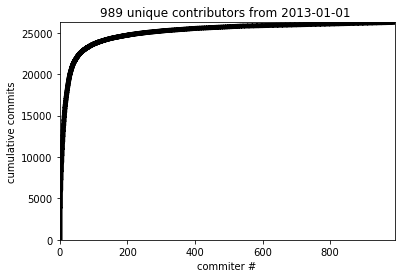

In [3]:
commiters = Counter(commits['name'])
commiter_number = list(range(len(commiters) + 1))
c_count = list(commiters.values())
cum_commits = np.r_[[0], np.cumsum(sorted(c_count, reverse=True))]

fig, ax = plt.subplots()
ax.step(commiter_number, cum_commits, where='post', color='k', lw=5)
ax.tick_params(axis='y', direction='out')
ax.tick_params(axis='x', direction='out')
ax.set_xlim([0, max(commiter_number)])
ax.set_ylim([0, np.sum(c_count)])
ax.set_ylabel('cumulative commits')
ax.set_xlabel('commiter #')
ax.set_title("{} unique contributors from 2013-01-01 ".
             format(max(commiter_number)-1));

Next we plot the number of commits and number of committers per week:

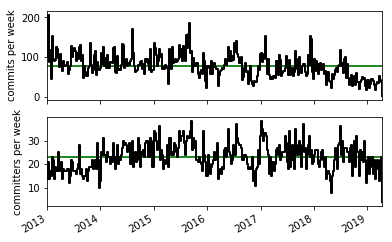

In [4]:
def stats_plotter(ax, left_edges, unq_by_week, col, ylabel):
    ln, = ax.step(left_edges,
                  unq_by_week[col], color='k', where='post', lw=2)

    hln = ax.axhline(unq_by_week[col].mean(), color='forestgreen', zorder=0, lw=2)
    ax.set_ylabel(ylabel)
    return ln, hln


def by_window_binner(ax1, ax2, commits, start, stop, step, window_name):
    edges = np.arange(start, stop + step, step)
    left_edges = [dt.datetime.fromtimestamp(t) for t in edges[:-1]]

    gb = commits.groupby(pd.cut(commits['time'], edges))
    unq_by_bin = gb.agg(lambda x: len(set(x)))
    
    stats_plotter(ax1, left_edges, unq_by_bin, 'time', 'commits per {}'.format(window_name))
    stats_plotter(ax2, left_edges, unq_by_bin, 'name', 'committers per {}'.format(window_name))

start = dt.datetime(2013, 1, 1).timestamp()
stop  = dt.datetime.now().timestamp()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
by_window_binner(ax1, ax2, commits, start, stop, 7*24*60*60, 'week')
ax1.set_xlim((dt.datetime(2013, 1, 1), dt.datetime(2019, 4, 10)))
fig.autofmt_xdate()

These plots suggest that Julia development has been burning along at a fairly
constant rate, until 2018, where the plots suggests that development rate has
fallen, apart from a burst around the time of the August 2018 first stable
release.

## Percentage of all Github pull requests

If Julia is gaining traction, I would expect there to be more Julia code reaching the open-source coding websites, such as Github.

I don't have those values, but [GitHut 2.0](https://madnight.github.io/githut)
does provide the *proportion* of Github pull-requests (PRs) for each language.
For example, in the case of Julia, we can see the proportion that is the number
of Github PRs in the Julia language, divided by the number of all PRs on Github
for the same period.

I scraped [these data](../downloads/julia_gh_prs.csv) by hand from the Githut site.

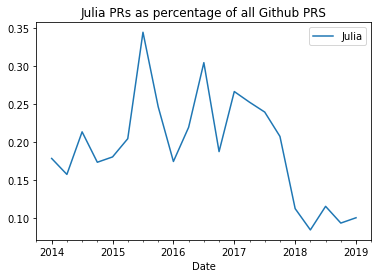

In [5]:
julia_prs = pd.read_csv('downloads/julia_gh_prs.csv')
julia_prs['Month'] = (julia_prs['Quarter'] - 1) * 3 + 2
datish = julia_prs.apply(
    lambda x: f"{x['Year']:0.0f}-{x['Month']:0.0f}", axis=1)
julia_prs['Date'] = pd.to_datetime(datish)

julia_prs.plot('Date', 'Julia')
plt.title("Julia PRs as percentage of all Github PRS");

Here are the values for Python, R and Julia in the first quarter of 2019:

In [9]:
julia_prs.iloc[0:1, :5]

,Year,Quarter,Python,R,Julia
0,2019,1,17.891,0.171,0.1


The PR numbers look rather like the commit plot for the Julia language repository, suggesting that activity dropped off in 2018, compared to 2017.

## TIOBE language index

The [TIOBE language index](https://www.tiobe.com/tiobe-index) tries to quantify the popularity of programming languages.  Quoting from the URL above:

> The ratings are based on the number of skilled engineers world-wide, courses
> and third party vendors. Popular search engines such as Google, Bing, Yahoo!,
> Wikipedia, Amazon, YouTube and Baidu are used to calculate the ratings

I recovered the TIOBE index for Julia for each month from January 2017 to April
\2019, using the archived versions of the URL above, from <https://archive.org>.

The data file with the index values is
[downloads/julia_tiobe.csv](../downloads/julia_tiobe.csv).

Some values were below the reporting threshold for the TIOBE index, in which case I gave Julia the index value for the lowest language that was reported.  This will be a slight overestimate of Julia's value.  I've marked these below-threshold values with orange dots.

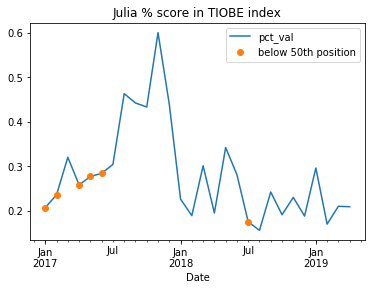

In [7]:
julia_tiobe = pd.read_csv('downloads/julia_tiobe.csv')
julia_tiobe['pct'] = julia_tiobe['pct'].apply(lambda x : x.strip())
julia_tiobe['below'] = julia_tiobe['pct'].apply(lambda x : x.startswith('<'))

def recode_pct(val):
    if val.startswith('<'):
        val = val[1:]
    return float(val)

julia_tiobe['pct_val'] = julia_tiobe['pct'].apply(recode_pct)
julia_tiobe['dt'] = pd.to_datetime(julia_tiobe['year_month'])

ax = julia_tiobe.plot('dt', 'pct_val')
belows = julia_tiobe[julia_tiobe['below']]
belows.plot('dt', 'pct_val', style='o', label='below 50th position', ax=ax)
plt.title('Julia % score in TIOBE index')
plt.xlabel('Date');

The plot looks a little like the commit numbers; the popularity index seems to
increase to a peak in late 2017, but drop in 2018 to a fairly steady low value,
of around 0.2%.  For comparison, the April 2018 values for Python and R were
8.166% and 1.181%, respectively.

## Redmonk Programming Language Rankings

Redmonk releases the [Redmonk ratings](https://redmonk.com/sogrady/category/programming-languages) every quarter.  Quoting from the [2019 first quarter ratings](https://redmonk.com/sogrady/2019/03/20/language-rankings-1-19) page:

> ... we extract language rankings from GitHub and Stack Overflow, and combine
> them for a ranking that attempts to reflect both code (GitHub) and discussion
> (Stack Overflow) traction.

Redmonk does not give tables with their graphics, that I can see, but here are the rankings for Julia, slightly guessed from figures quoted in the text of the various quarterly reports:

| Year | Quarter | Position |
|------|---------|----------|
| 2018 | 4       | 34       |
| 2018 | 2       | 36       |
| 2018 | 1       | 39       |
| 2017 | 4       | 40       |
| 2017 | 3       | 52       |

These rankings are a bit more positive for Julia, suggesting that it is slowly climbing in popularity.